In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

import matplotlib.pyplot as plt

use_cuda= torch.cuda.is_available

%matplotlib inline


### Objective:

predict integer-valued time series data for prediction with seq2seq method, using artificial embedding associated with one-hot representation of the data.


### Data kaggle

In [2]:
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import pandas as pd

path = '/Users/Doudou/Documents/Scolarité/MASH/Kaggle/Recruiting holding'

from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf

def RMLSE(p,a):
    x = np.sqrt(np.mean((np.log(p+1)-np.log(a+1))**2))
    return x

df_air_reserve = pd.read_csv(path+'/air_reserve.csv', parse_dates=['visit_datetime','reserve_datetime'], encoding='utf-8')
df_air_store_info = pd.read_csv(path+'/air_store_info.csv', encoding='utf-8')
df_air_visit_data = pd.read_csv(path+'/air_visit_data.csv', parse_dates=['visit_date'], encoding='utf-8')
df_date_info = pd.read_csv(path+'/date_info.csv', parse_dates=['calendar_date'], encoding='utf-8')
df_hpg_reserve = pd.read_csv(path+'/hpg_reserve.csv', parse_dates=['visit_datetime','reserve_datetime'], encoding='utf-8')
df_hpg_store_info = pd.read_csv(path+'/hpg_store_info.csv', encoding='utf-8')
df_sample_submission = pd.read_csv(path+'/sample_submission.csv', encoding='utf-8')
df_store_id_relation = pd.read_csv(path+'/store_id_relation.csv', encoding='utf-8')


/Users/Doudou/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
df_sample_submission['air_store_id'] = df_sample_submission.id.apply(lambda d: str(d)[:-11])
df_sample_submission['visit_date'] = df_sample_submission.id.apply(lambda d: str(d)[-10:])
df_sample_submission.visit_date = pd.to_datetime(df_sample_submission.visit_date)


In [4]:
df_air_visit_data = pd.concat((df_air_visit_data, df_sample_submission.drop('id', axis=1)))


In [5]:
df_air_visit_data_save = df_air_visit_data.copy()


### Treatment of data

#### Only get recent dates

In [6]:
df_air_visit_data = df_air_visit_data.loc[(df_air_visit_data.visit_date>datetime.strptime('2017-01-01', '%Y-%m-%d').date())*(df_air_visit_data.visit_date<=datetime.strptime('2017-04-22', '%Y-%m-%d').date())]


/Users/Doudou/anaconda/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


#### Padding the missing/closing dates with zeros

In [7]:
asis = np.unique(df_air_visit_data.air_store_id.values)
idx = pd.date_range(df_air_visit_data.loc[df_air_visit_data.air_store_id==asis[0]].visit_date.min(), 
                    df_air_visit_data.loc[df_air_visit_data.air_store_id==asis[0]].visit_date.max())

df_reindexed = df_air_visit_data.loc[df_air_visit_data.air_store_id==asis[0]].set_index(['visit_date']).reindex(idx, fill_value=0)
df_reindexed.air_store_id = asis[0]

for asi in asis[1:]:
    idx = pd.date_range(df_air_visit_data.loc[df_air_visit_data.air_store_id==asi].visit_date.min(), 
                    df_air_visit_data.loc[df_air_visit_data.air_store_id==asi].visit_date.max())
    df_temp = df_air_visit_data.loc[df_air_visit_data.air_store_id==asi].set_index(['visit_date']).reindex(idx, fill_value=0)
    df_temp.air_store_id = asi
    df_reindexed = pd.concat((df_reindexed, df_temp))


In [8]:
df_reindexed['visit_date'] = df_reindexed.index
df_reindexed.reset_index(drop=True, inplace = True)
print(df_reindexed.shape)


(88795, 3)


In [9]:
df_air_visit_data = df_reindexed.copy()


df_reindexed=df_air_visit_data.copy()

In [10]:
df_reindexed

,air_store_id,visitors,visit_date
0,air_00a91d42b08b08d9,17,2017-01-04
1,air_00a91d42b08b08d9,22,2017-01-05
2,air_00a91d42b08b08d9,36,2017-01-06
3,air_00a91d42b08b08d9,21,2017-01-07
4,air_00a91d42b08b08d9,0,2017-01-08
5,air_00a91d42b08b08d9,0,2017-01-09
6,air_00a91d42b08b08d9,37,2017-01-10
7,air_00a91d42b08b08d9,27,2017-01-11
8,air_00a91d42b08b08d9,15,2017-01-12
9,air_00a91d42b08b08d9,44,2017-01-13


df_reindexed.visitors = (df_reindexed.visitors-df_reindexed.visitors%5)/5

In [11]:
df_reindexed['visitors']=df_reindexed['visitors'].astype(int, copy=False)

In [324]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input
from keras.utils import to_categorical

win_X = 21
win_y = 7

SOS_token = int(df_reindexed.visitors.max()+1)
EOS_token = int(df_reindexed.visitors.max()+2)

ds = np.unique(df_reindexed.air_store_id.values)[:1]

pairs_TS = []

for asi in ds:
    df_temp = df_reindexed.set_index(['air_store_id', 'visit_date']).loc[asi]
    
    pairs_one_TS = [(Variable(torch.LongTensor(np.expand_dims(np.insert(df_temp.iloc[i:i+win_X].values,win_X, EOS_token),
                                                              axis=1)).view(-1,1)), 
                     Variable(torch.LongTensor(np.expand_dims(np.insert(df_temp.iloc[i+win_X:i+win_X+win_y].values,win_y, EOS_token),
                                                              axis=1)).view(-1,1))) 
                    for i in np.arange(df_temp.shape[0]-win_X-win_y)]
    
    pairs_TS = pairs_TS + pairs_one_TS
    

In [325]:
pairs_TS[10]

(Variable containing:
    17
     0
    20
    24
    37
    22
    46
   879
 [torch.LongTensor of size 8x1], Variable containing:
    11
     0
    18
    29
    26
    36
    39
   879
 [torch.LongTensor of size 8x1])

### Training with traditionnal decoder

### Encoder-decoder structure

In [326]:
class EncoderRNN(nn.Module): #nn.Module = base class for all NN modules --> each model subclass this class
    
    def __init__(self, input_size, hidden_size, n_layers=1):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding=nn.Embedding(input_size, hidden_size) # lookup table that stores embedding of fixed dictionary
        # input_size is the number of variable to embed
        # hidden_size is the number of dimensions for each embedding
        self.gru=nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1) # view(shape) returns self tensors data with a different shape
        output = embedded
        for i in np.arange(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden
            
    def initHidden(self):
        result=Variable(torch.zeros(1,1,self.hidden_size)) # creates a tensor of zeros, compatible with automatic gradient computing
        return result
        

In [327]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding=nn.Embedding(output_size, hidden_size)
        self.gru=nn.GRU(hidden_size, hidden_size)
        self.out=nn.Linear(hidden_size, output_size)
        self.softmax=nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        output=self.embedding(input).view(1,1,-1)
        for i in np.arange(self.n_layers):
            output=F.relu(output)
            output, hidden=self.gru(output, hidden)
        output=self.softmax(self.out(output[0]))
        return output, hidden
        
    def initHidden(self):
        result=Variable(torch.zeros(1,1,self.hidden_size))
        return result
    

In [328]:
n_iters = 10000
learning_rate=0.01
teacher_forcing_ratio=0.2

training_pairs=[random.choice(pairs_TS[:-10]) for i in np.arange(n_iters)]

hidden_size = 256
MAX_LENGTH = training_pairs[0][0].shape[0]

encoder1=EncoderRNN(EOS_token+1, hidden_size)
decoder1=DecoderRNN(hidden_size, EOS_token+1)
use_cuda=False

encoder_optimizer=optim.SGD(encoder1.parameters(), lr=learning_rate)
decoder_optimizer=optim.SGD(decoder1.parameters(), lr=learning_rate)

criterion=nn.CrossEntropyLoss()


In [329]:
total_loss = []

for i in np.arange(n_iters):

    encoder_hidden = encoder1.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_variable = training_pairs[i][0]
    target_variable = training_pairs[i][1]
    
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder1.hidden_size))

    loss=0

    for ei in np.arange(input_length):
        encoder_output, encoder_hidden = encoder1(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]


    #decoder_input=Variable(torch.LongTensor([[int(input_variable[ei-1].data[0])]]))
    decoder_input=Variable(torch.LongTensor([[SOS_token]]))

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for di in np.arange(target_length):
            decoder_output, decoder_hidden=decoder1(decoder_input, decoder_hidden)
            loss+=criterion(decoder_output, target_variable[di])
            decoder_input=target_variable[di]

    else:
        for di in np.arange(target_length):
            decoder_output, decoder_hidden=decoder1(decoder_input, decoder_hidden)

            # we want to extract the best prediction (highest softmax-estimated probability value, see DecoderRNN.forward function)
            # we then select the index related to the highest NLLL
            top_value, top_index = decoder_output.data.topk(1)

            #decoder_input=Variable(torch.LongTensor([[SOS_token]]))
            decoder_input=Variable(torch.LongTensor([[top_index[0][0]]]))

            loss+=criterion(decoder_output, target_variable[di])

            if top_index[0][0]==EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_loss.append(loss.data[0]/target_length)


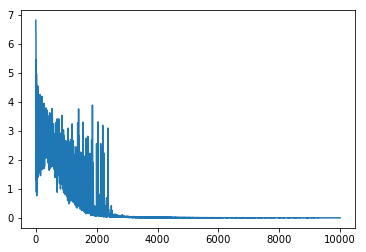

In [330]:
plt.plot(total_loss)


### Evaluation

In [331]:
n_tests = 10
testing_pairs=[random.choice(pairs_TS[-10:]) for i in range(n_tests)]


In [332]:
#input_variable = variableFromSentence(input_lang, 'je suis institutrice .')
decoder_sentences = []

for tp in testing_pairs:
    input_variable = tp[0]
    input_length = input_variable.size()[0]
    encoder_hidden=encoder1.initHidden()

    encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder1.hidden_size))

    for ei in np.arange(input_length):
        encoder_output, encoder_hidden = encoder1(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]+encoder_outputs[ei]

    decoder_input = Variable(torch.LongTensor([[int(SOS_token)]]))

    decoder_hidden = encoder_hidden

    decoded_words=[]

    for di in np.arange(win_y):
        decoder_output, decoder_hidden=decoder1(decoder_input, decoder_hidden)
        top_value, top_index = decoder_output.data.topk(1)

        decoded_words.append(top_index[0][0])

        decoder_input = Variable(torch.LongTensor([[top_index[0][0]]]))
    
    decoder_sentences.append(decoded_words+[EOS_token])
    

In [333]:
decoder_sentences


[[38, 39, 37, 4, 0, 0, 28, 879],
 [18, 0, 15, 36, 33, 40, 28, 879],
 [18, 31, 28, 42, 39, 37, 4, 879],
 [35, 29, 17, 9, 0, 17, 43, 879],
 [38, 39, 37, 4, 0, 0, 28, 879],
 [30, 52, 33, 38, 7, 0, 33, 879],
 [0, 18, 29, 26, 36, 39, 7, 879],
 [18, 0, 15, 36, 33, 40, 28, 879],
 [35, 29, 17, 9, 0, 17, 43, 879],
 [7, 0, 43, 30, 52, 33, 38, 879]]

In [334]:
for i,tp in enumerate(testing_pairs):
    print(np.array(tp[1].data.view(1,-1)).flatten())
    

[ 34  39   0   0  19  35  17 879]
[ 17   9   0  17  43  28  34 879]
[ 17  43  28  34  39   0   0 879]
[ 29  17   9   0  17  43  28 879]
[ 34  39   0   0  19  35  17 879]
[ 28  34  39   0   0  19  35 879]
[  9   0  17  43  28  34  39 879]
[ 17   9   0  17  43  28  34 879]
[ 29  17   9   0  17  43  28 879]
[ 39   0   0  19  35  17  38 879]


In [335]:
total_loss=[]

for i,tp in enumerate(testing_pairs):
    e=RMLSE((np.array(tp[1].data.view(1,-1)).flatten()),
                np.array(decoder_sentences[i]))
    print(e)
    total_loss.append(e)
    

2.17593399633
1.31020051339
1.41284440823
1.38150891148
2.17593399633
1.83461435122
1.46366504887
1.31020051339
1.38150891148
1.48561956813


In [336]:
np.mean(total_loss)


1.5932030218826134

### Training with attention decoder

In [234]:
class EncoderRNN(nn.Module): #nn.Module = base class for all NN modules --> each model subclass this class
    
    def __init__(self, input_size, hidden_size, n_layers=1):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding=nn.Embedding(input_size, hidden_size)
        self.gru=nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1) # view(shape) returns self tensors data with a different shape
        output = embedded
        for i in np.arange(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden
        
    def initHidden(self):
        result=Variable(torch.zeros(1,1,self.hidden_size)) # creates a tensor of zeros, compatible with automatic gradient computing
        return result
        

In [235]:
class AttentionDecoder_RNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, 
                 max_length=MAX_LENGTH):
        super().__init__()
        self.n_layers=n_layers
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.dropout_p=dropout_p
        self.max_length=max_length
        
        self.embedding=nn.Embedding(self.output_size, self.hidden_size)
        
        # attention layer gets decoder's prev_hidden layer (initialized with encoder's hidden layer) and decoder's input
        # the attention mechanism is simply a linear filtering method, outputing a focused transformation of the input
        
        self.attn=nn.Linear(self.hidden_size*2, self.max_length)
        self.attn_combine=nn.Linear(self.hidden_size*2,self.hidden_size)
        self.dropout=nn.Dropout(self.dropout_p)
        self.gru=nn.GRU(self.hidden_size, self.hidden_size)
        self.out=nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded=self.embedding(input).view(1,1,-1)
        embedded=self.dropout(embedded)
        
        attn_weights=torch.cat((embedded[0], hidden[0]), dim=1)
        attn_weights=F.softmax(self.attn(attn_weights), dim=1)
        
        # bmm is a batch matrix multiplication for 3D tensors with first dimension equals number of matrices
        # unsqueeze(d) insert a dimension of size 1 at position d
        
        attn_applied=torch.bmm(attn_weights.unsqueeze(0), 
                               encoder_outputs.unsqueeze(0))
        
        output=torch.cat((embedded[0], attn_applied[0]), 1)
        output=self.attn_combine(output).unsqueeze(0)
        
        for i in np.arange(self.n_layers):
            output=F.relu(output)
            output, hidden=self.gru(output, hidden)
            
        output=F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hidden, attn_weights
    
    def initHidden(self):
        result=Variable(torch.zeros(1,1,self.hidden_size))
        return result
    

In [236]:
n_iters = 10000
learning_rate=0.01
teacher_forcing_ratio=0.2

training_pairs=[random.choice(pairs_TS[:-10]) for i in np.arange(n_iters)]

hidden_size = 256

MAX_LENGTH = training_pairs[0][0].shape[0]
max_length = MAX_LENGTH

encoder=EncoderRNN(EOS_token+1, hidden_size)
decoder_attn=AttentionDecoder_RNN(hidden_size, EOS_token+1)
use_cuda=False

encoder_optimizer=optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer=optim.SGD(decoder_attn.parameters(), lr=learning_rate)

criterion=nn.NLLLoss()


In [237]:
%%time

total_loss = []

for i in np.arange(n_iters):

    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_variable = training_pairs[i][0]
    target_variable = training_pairs[i][1]
    
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))

    loss=0

    for ei in np.arange(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]
    
    #decoder_input=Variable(torch.LongTensor([[int(input_variable[ei-1].data[0])]]))

    decoder_input=Variable(torch.LongTensor([[SOS_token]]))
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        
        for di in np.arange(target_length):
            decoder_output, decoder_hidden, decoder_attention=decoder_attn(decoder_input, decoder_hidden, encoder_outputs)
            loss+=criterion(decoder_output, target_variable[di])
            decoder_input=target_variable[di]

    else:
        
        for di in np.arange(target_length):
            decoder_output, decoder_hidden, decoder_attention=decoder_attn(decoder_input, decoder_hidden, encoder_outputs)
            top_value, top_index = decoder_output.data.topk(1)
            
            decoder_input=Variable(torch.LongTensor([[top_index[0][0]]]))
            #decoder_input=Variable(torch.LongTensor([[SOS_token]]))
            
            loss+=criterion(decoder_output, target_variable[di])

            if top_index[0][0]==EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_loss.append(loss.data[0]/target_length)



CPU times: user 1h 6min 42s, sys: 13min 13s, total: 1h 19min 56s
Wall time: 32min 26s


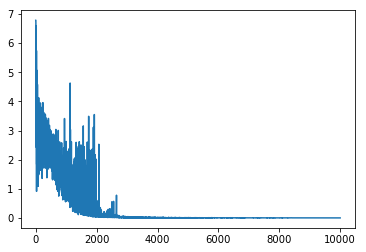

In [238]:
plt.plot(total_loss)


In [239]:
#input_variable = variableFromSentence(input_lang, 'je suis institutrice .')
decoder_sentences = []

for tp in training_pairs[:20]:
    input_variable = tp[0]
    input_length = input_variable.size()[0]
    encoder_hidden=encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))

    for ei in np.arange(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]+encoder_outputs[ei]

    #decoder_input = Variable(torch.LongTensor([[int(input_variable.data[-2])]]))
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))

    decoder_hidden = encoder_hidden

    decoded_words=[]

    for di in np.arange(win_y):
        decoder_output, decoder_hidden, decoder_attention=decoder_attn(decoder_input, decoder_hidden, encoder_outputs)
        top_value, top_index = decoder_output.data.topk(1)

        #if top_index[0][0]==EOS_token:
        #    decoded_words.append('<EOS_token>')
        #    break
        #else:
            #decoded_words.append(output_lang.index2word[top_index[0][0]])
        decoded_words.append(top_index[0][0])

        # we use guess as new input for the decoder
        #decoder_input = Variable(torch.LongTensor([[SOS_token]]))
        decoder_input = Variable(torch.LongTensor([[top_index[0][0]]]))
        
    decoded_words.append(EOS_token)
    decoder_sentences.append(decoded_words)
    

In [240]:
np.array(decoder_sentences)

array([[  0,  16,  28,  27,  24,  37,  23, 879],
       [ 52,  33,  38,   7,   0,  33,  17, 879],
       [ 33,  17,  35,  29,  17,   9,   0, 879],
       [  9,   0,  39,  28,  42,  39,  37, 879],
       [  0,  24,  41,  52,  35,  45,  18, 879],
       [ 29,  18,   0,  18,  31,  28,  38, 879],
       [ 33,  29,  18,   0,  18,  31,  28, 879],
       [  7,   0,  33,  17,  35,  29,  17, 879],
       [ 23,  27,  34,   7,   0,  43,  30, 879],
       [ 28,  42,  39,  37,   4,   0,   0, 879],
       [ 23,   0,  37,  32,  15,  30,  26, 879],
       [ 40,  28,  11,   0,  34,  19,  17, 879],
       [  0,   0,  24,  41,  52,  35,  45, 879],
       [ 19,  17,  33,  29,  18,   0,  18, 879],
       [ 38,   7,   0,  33,  17,  35,  29, 879],
       [  0,  37,  32,  15,  30,  26,   0, 879],
       [ 52,  35,  45,  18,   0,  15,  36, 879],
       [ 52,  35,  45,  18,   0,  15,  36, 879],
       [  0,  33,  17,  35,  29,  17,   9, 879],
       [ 17,  35,  29,  17,   9,   0,  17, 879]])

In [241]:
for i,tp in enumerate(training_pairs[:20]):
    print(np.array(tp[1].data.view(1,-1)).flatten())
    

[  0  16  28  27  24  37  23 879]
[ 52  33  38   7   0  33  17 879]
[ 33  17  35  29  17   9   0 879]
[  9   0  39  28  42  39  37 879]
[  0  24  41  52  35  45  18 879]
[ 29  18   0  18  31  28  38 879]
[ 33  29  18   0  18  31  28 879]
[  7   0  33  17  35  29  17 879]
[ 23  27  34   7   0  43  30 879]
[ 28  42  39  37   4   0   0 879]
[ 23   0  37  32  15  30  26 879]
[ 40  28  11   0  34  19  17 879]
[  0   0  24  41  52  35  45 879]
[ 19  17  33  29  18   0  18 879]
[ 38   7   0  33  17  35  29 879]
[  0  37  32  15  30  26   0 879]
[ 52  35  45  18   0  15  36 879]
[ 52  35  45  18   0  15  36 879]
[  0  33  17  35  29  17   9 879]
[ 17  35  29  17   9   0  17 879]


In [242]:
total_RMLSE=[]

for i,tp in enumerate(training_pairs[:20]):
    total_RMLSE.append(RMLSE((np.array(tp[1].data.view(1,-1)).flatten())[:-2],
                np.array(decoder_sentences[i])[:-2]))
    print(total_RMLSE[-1])


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


### Evaluation

In [243]:
n_tests = 10

testing_pairs=[pairs_TS[-10:][i] for i in np.arange(n_tests)]


In [244]:
encoder_hidden.shape

torch.Size([1, 1, 256])

In [316]:
#input_variable = variableFromSentence(input_lang, 'je suis institutrice .')
decoder_sentences = []

for tp in testing_pairs:
    input_variable = tp[0]
    input_length = input_variable.size()[0]
    encoder_hidden=encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))

    for ei in np.arange(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]+encoder_outputs[ei]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))

    decoder_hidden = encoder_hidden

    decoded_words=[]

    for di in np.arange(win_y):
        decoder_output, decoder_hidden, decoder_attention=decoder_attn(decoder_input, decoder_hidden, encoder_outputs)
        top_value, top_index = decoder_output.data.topk(1)

        #if top_index[0][0]==EOS_token:
        #    decoded_words.append('<EOS_token>')
        #    break
        #else:
            #decoded_words.append(output_lang.index2word[top_index[0][0]])
        decoded_words.append(top_index[0][0])

        # we use guess as new input for the decoder
        #decoder_input = Variable(torch.LongTensor([[SOS_token]]))
        decoder_input = Variable(torch.LongTensor([[top_index[0][0]]]))
        
    decoded_words.append(EOS_token)
    decoder_sentences.append(decoded_words)
    

In [317]:
a=np.array(decoder_sentences)*np.array(np.array([np.array(tp[1].data.view(1,-1)).flatten() 
          for i, tp in enumerate(testing_pairs)])!=0,dtype=int)


In [318]:
for i,tp in enumerate(testing_pairs):
    print(np.array(tp[0].data.view(1,-1)).flatten())
    

[ 39  37   4   0   0  28  23  27  34   7   0  43  30  52  33  38   7   0
  33  17  35 879]
[ 37   4   0   0  28  23  27  34   7   0  43  30  52  33  38   7   0  33
  17  35  29 879]
[  4   0   0  28  23  27  34   7   0  43  30  52  33  38   7   0  33  17
  35  29  17 879]
[  0   0  28  23  27  34   7   0  43  30  52  33  38   7   0  33  17  35
  29  17   9 879]
[  0  28  23  27  34   7   0  43  30  52  33  38   7   0  33  17  35  29
  17   9   0 879]
[ 28  23  27  34   7   0  43  30  52  33  38   7   0  33  17  35  29  17
   9   0  17 879]
[ 23  27  34   7   0  43  30  52  33  38   7   0  33  17  35  29  17   9
   0  17  43 879]
[ 27  34   7   0  43  30  52  33  38   7   0  33  17  35  29  17   9   0
  17  43  28 879]
[ 34   7   0  43  30  52  33  38   7   0  33  17  35  29  17   9   0  17
  43  28  34 879]
[  7   0  43  30  52  33  38   7   0  33  17  35  29  17   9   0  17  43
  28  34  39 879]


In [2]:
np.array(decoder_sentences)

NameError: name 'np' is not defined

In [320]:
for i,tp in enumerate(testing_pairs):
    print(np.array(tp[1].data.view(1,-1)).flatten())
    

[ 29  17   9   0  17  43  28 879]
[ 17   9   0  17  43  28  34 879]
[  9   0  17  43  28  34  39 879]
[  0  17  43  28  34  39   0 879]
[ 17  43  28  34  39   0   0 879]
[ 43  28  34  39   0   0  19 879]
[ 28  34  39   0   0  19  35 879]
[ 34  39   0   0  19  35  17 879]
[ 39   0   0  19  35  17  38 879]
[  0   0  19  35  17  38  55 879]


In [321]:
total_RMLSE=[]

for i,tp in enumerate(testing_pairs):
    total_RMLSE.append(RMLSE((np.array(tp[1].data.view(1,-1)).flatten()),
                np.array(decoder_sentences[i])))
    print(total_RMLSE[-1])


1.31721049126
1.35023103054
0.256910158026
2.40008820918
0.822947775808
2.22432912778
0.856308597558
0.908237012409
1.9594046264
1.24488246749


In [322]:
total_RMLSE_zeros=[]

for i,tp in enumerate(testing_pairs):
    total_RMLSE_zeros.append(RMLSE((np.array(tp[1].data.view(1,-1)).flatten())[:-2],a[i][:-2]))
    print(total_RMLSE_zeros[-1])
    

1.00608087576
0.991416423752
0.296654297787
0.13907205757
0.13907205757
1.53017791442
0.293673506607
0.299698633757
1.25216659308
0.284641487567


In [323]:
print(np.mean(total_RMLSE))
print(np.mean(total_RMLSE_zeros))


1.33405494964
0.623265384787


### PROBLEM WITH THE DETECTION OF THE ZEROS

Necessity to use contextual variables (days of the week, localisation, meteorological data, ...) and longer and deeper training